Random Forest MSE: 2.422943804087181, MAE: 1.3073376916302248


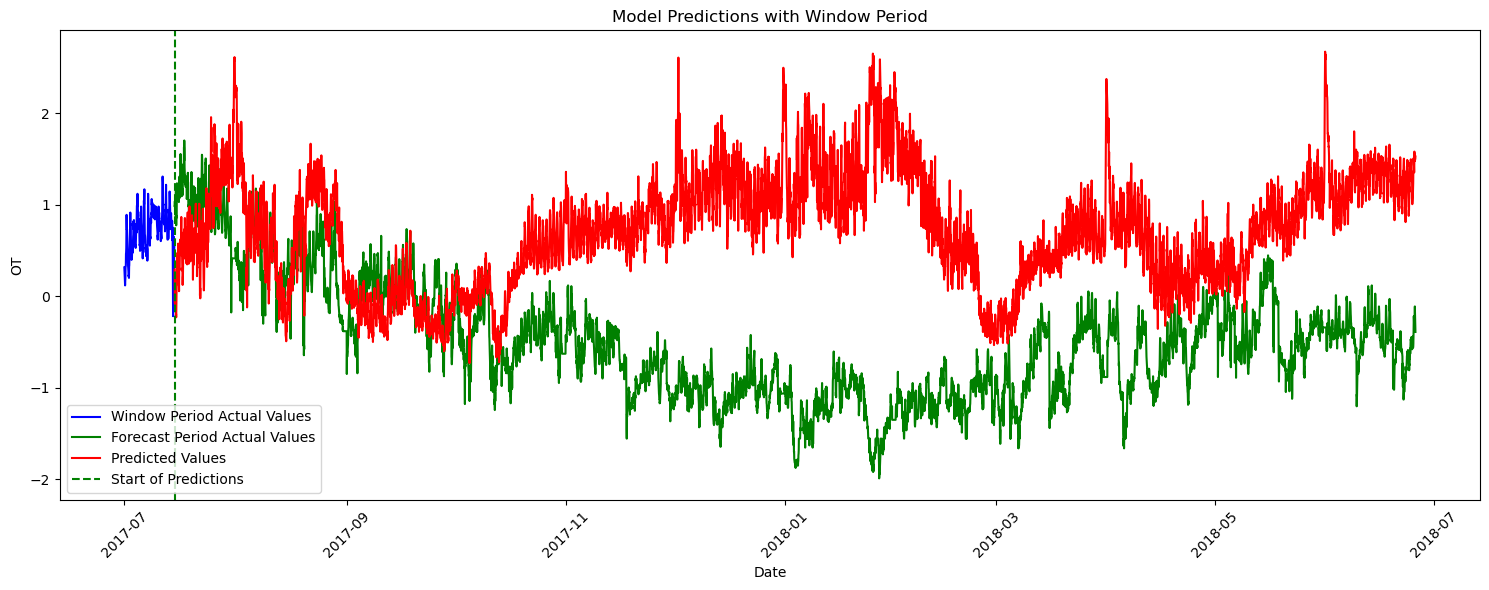

In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 加载数据
data_path = '/Users/yuanxiaoyang/Desktop/machine learning code packs/袁潇洋笔试题/袁潇洋笔试题A/ETTh1.csv'  # 请替换为实际的文件路径
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])

# 标准化数据（除了日期列）
scaler = StandardScaler()
df[df.columns.difference(['date'])] = scaler.fit_transform(df[df.columns.difference(['date'])])

# 创建滚动窗口的函数
def create_rolling_windows(X, Y, lookback=336, forecast_horizon=24):
    Xs, Ys = [], []
    for i in range(len(X) - lookback - forecast_horizon + 1):
        Xs.append(X[i:(i + lookback)].flatten())  # 确保X是展平的
        Ys.append(Y[i + lookback])  # Y应该选择一个值而不是数组
    return np.array(Xs), np.array(Ys)


# 划分训练集和测试集
train_df = df[df['date'] < '2017-07-01']
test_df = df[df['date'] >= '2017-07-01']

# 选择目标变量 - 这里以外部温度 OT 为例
target_column = 'OT'

# 准备输入输出数据
X_train = train_df.drop(columns=['date', target_column]).values
Y_train = train_df[target_column].values
X_test = test_df.drop(columns=['date', target_column]).values
Y_test = test_df[target_column].values

# 创建滚动窗口
lookback = 336  # 根据需要调整
forecast_horizon = 24  # 根据需要调整
X_train_rolled, Y_train_rolled = create_rolling_windows(X_train, Y_train, lookback, forecast_horizon)
X_test_rolled, Y_test_rolled = create_rolling_windows(X_test, Y_test, lookback, forecast_horizon)

# 训练随机森林模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_rolled, Y_train_rolled)

# 进行预测
predictions = model.predict(X_test_rolled.reshape(X_test_rolled.shape[0], -1))

# 评估模型
mse = mean_squared_error(Y_test_rolled.ravel(), predictions)
mae = mean_absolute_error(Y_test_rolled.ravel(), predictions)
print(f'Random Forest MSE: {mse}, MAE: {mae}')

# 结果可视化
# 首先，确定预测开始的实际日期
prediction_start_date = test_df['date'].iloc[lookback]

# 找到窗口期最后的实际值对应的日期范围
window_dates = test_df['date'].iloc[:lookback]

# 计算绘图所需的实际值和预测值的日期范围
actual_dates = test_df['date'].iloc[lookback:lookback+len(predictions)]

plt.figure(figsize=(15, 6))

# 绘制窗口期的实际值
plt.plot(window_dates, Y_train[-lookback:], label='Window Period Actual Values', color='blue')

# 绘制预测期的实际值
plt.plot(actual_dates, Y_test_rolled.ravel(), label='Forecast Period Actual Values', color='green')

# 绘制预测值
plt.plot(actual_dates, predictions, label='Predicted Values', color='red')

# 用绿色线标记预测的开始
plt.axvline(x=prediction_start_date, color='green', linestyle='--', label='Start of Predictions')

plt.legend()
plt.title('Model Predictions with Window Period')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

